# ML Pipeline Preparation
Follow the instructions below to help you create your ML pipeline.
### 1. Import libraries and load data from database.
- Import Python libraries
- Load dataset from database with [`read_sql_table`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_sql_table.html)
- Define feature and target variables X and Y

In [1]:
# import libraries
from tempfile import mkdtemp
from shutil import rmtree
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
import re
import nltk
import time
import pickle
from joblib import parallel_backend

nltk.download(['punkt', 'stopwords', 'wordnet', 'omw-1.4'])

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import classification_report
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.utils.multiclass import unique_labels
from sklearn.compose import ColumnTransformer

import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)
%matplotlib inline

[nltk_data] Downloading package punkt to /home/guilherme/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/guilherme/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/guilherme/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/guilherme/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
# load data from database
engine = create_engine('sqlite:////home/guilherme/Documents/Projetos/Udacity_Data_Science/disaster_response_pipeline_project/data/DisasterResponse.db')
df = pd.read_sql_table('DisasterResponse', engine)
df.head()
X = df[['message', 'original', 'genre']]
Y = df.iloc[:,4:]

## DELETE ME
---

In [3]:
X = X.iloc[:1000]
Y = Y.iloc[:1000]

### 2. Write a tokenization function to process your text data

In [4]:
def tokenize(text):
    
    #remove urls
    url_regex = r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    detected_urls = re.findall(url_regex, text)
    for url in detected_urls:
        text = text.replace(url, 'urlplaceholder')
    
    #Text Tokenization
    words = word_tokenize(text.lower(), language='english')
    
    words=[word for word in words if word.isalnum() or len(word) > 1]
    
    # Tokenize
    words = word_tokenize(text)
    
    # Remove stop words
    stop = set(stopwords.words('english'))
    words = [w for w in words if w not in stop]
    
    # Words Lemmatization
    words = [WordNetLemmatizer().lemmatize(w, pos='v') for w in words]
    
    # Words Stemming
    
    words = [PorterStemmer().stem(w) for w in words]
    
    return words

### 3. Build a machine learning pipeline
This machine pipeline should take in the `message` column as input and output classification results on the other 36 categories in the dataset. You may find the [MultiOutputClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputClassifier.html) helpful for predicting multiple target variables.

In [5]:
cachedir = mkdtemp()
model = Pipeline([('preprocess', ColumnTransformer([('categories', OneHotEncoder(dtype='int'), ['genre']),
                                                    ('messages', Pipeline([('count', CountVectorizer(tokenizer=tokenize)),
                                                                           ('tfidf', TfidfTransformer())]), 
                                                     'message')], 
                                   remainder='drop', verbose_feature_names_out=False)),
                  ('clf', MultiOutputClassifier(RandomForestClassifier()))],
                memory=cachedir, verbose = True)

### 4. Train pipeline
- Split data into train and test sets
- Train pipeline

In [6]:
CountVectorizer().build_tokenizer

<bound method _VectorizerMixin.build_tokenizer of CountVectorizer()>

In [7]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y)

In [8]:
startTime = time.time()

In [9]:
with parallel_backend('threading', n_jobs=-3):
    model.fit(X_train, Y_train)

/home/guilherme/anaconda3/envs/Udacity/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['quoted_name']. An error will be raised in 1.2.
  warnings.warn(
/home/guilherme/anaconda3/envs/Udacity/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['quoted_name']. An error will be raised in 1.2.
  warnings.warn(
/home/guilherme/anaconda3/envs/Udacity/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['quoted_name']. An error will be raised in 1.2.
  warnings.warn(


[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   1.7s
[Pipeline] ............... (step 2 of 2) Processing clf, total=   5.9s


In [10]:
executionTime = time.time() - startTime

In [11]:
print(f'Execution time: {executionTime//3600:02.0f}:{(executionTime%3600)//60:02.0f}:{(executionTime%60):02.03f}')

Execution time: 00:00:7.769


In [12]:
len(model['preprocess'].get_feature_names_out())

1937

### 5. Test your model
Report the f1 score, precision and recall for each output category of the dataset. You can do this by iterating through the columns and calling sklearn's `classification_report` on each.

In [13]:
startTime = time.time()
y_pred = model.predict(X_test)
executionTime = time.time() - startTime
print(f'Execution time: {executionTime//3600:02.0f}:{(executionTime%3600)//60:02.0f}:{(executionTime%60):02.03f}')

/home/guilherme/anaconda3/envs/Udacity/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['quoted_name']. An error will be raised in 1.2.
  warnings.warn(


Execution time: 00:00:0.673


In [14]:
labels = Y_test.columns

In [15]:
for i in range(36):    
    print(labels[i])
    print(classification_report(Y_test.values[:,i], y_pred[:,i]))

related
              precision    recall  f1-score   support

           0       0.43      0.08      0.14        36
           1       0.86      0.98      0.91       212
           2       0.00      0.00      0.00         2

    accuracy                           0.84       250
   macro avg       0.43      0.35      0.35       250
weighted avg       0.79      0.84      0.80       250

request
              precision    recall  f1-score   support

           0       0.78      0.65      0.71       107
           1       0.77      0.86      0.81       143

    accuracy                           0.77       250
   macro avg       0.77      0.76      0.76       250
weighted avg       0.77      0.77      0.77       250

offer
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       250

    accuracy                           1.00       250
   macro avg       1.00      1.00      1.00       250
weighted avg       1.00      1.00      1.00       25

/home/guilherme/anaconda3/envs/Udacity/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/guilherme/anaconda3/envs/Udacity/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/guilherme/anaconda3/envs/Udacity/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

In [16]:
def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title=None, cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


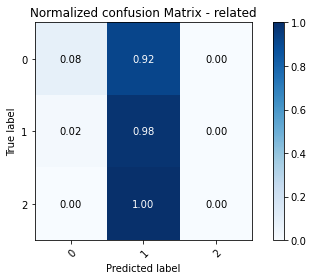

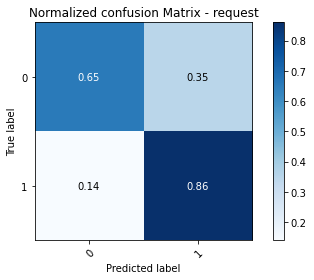

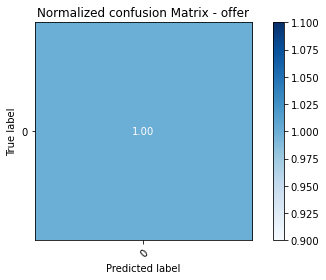

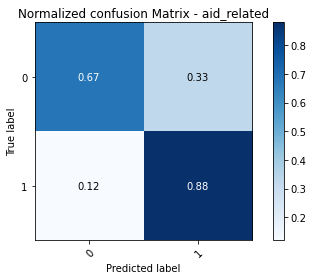

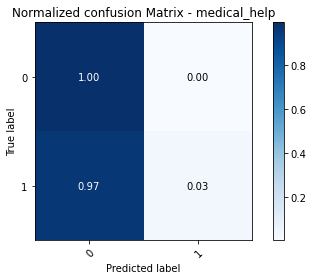

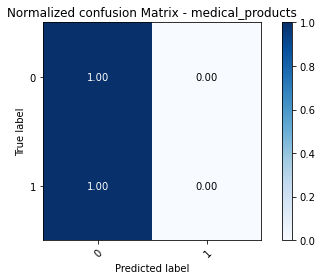

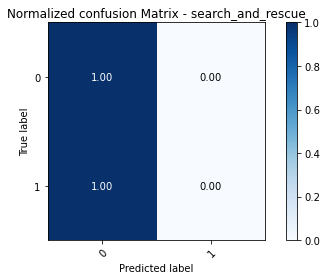

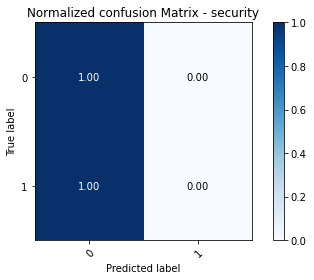

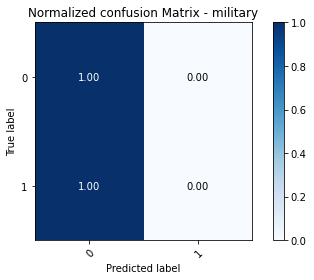

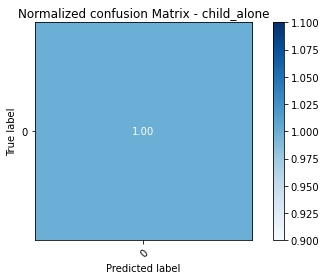

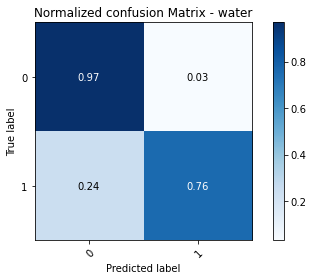

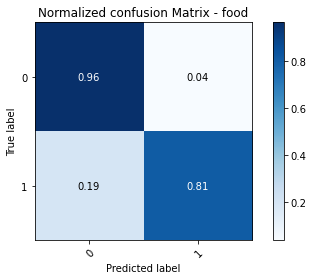

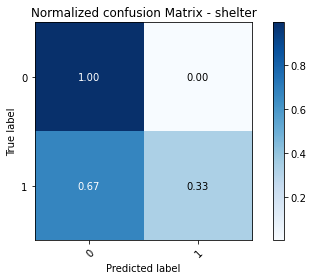

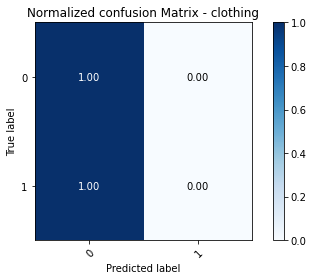

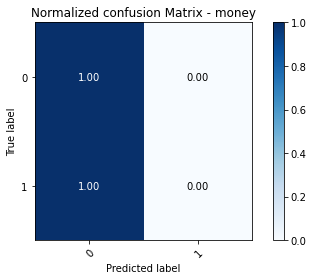

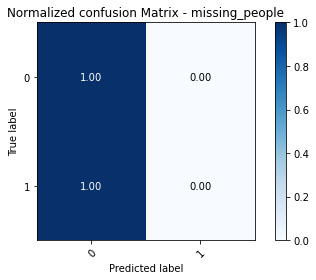

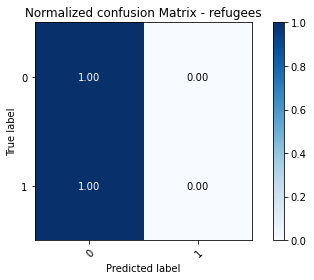

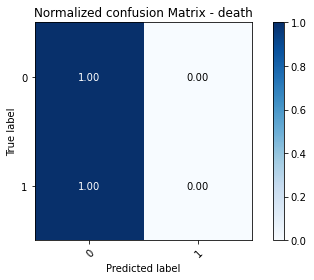

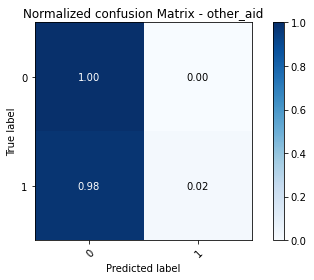

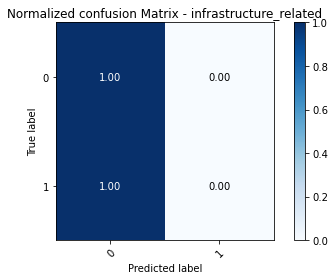

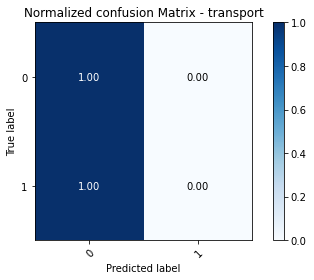

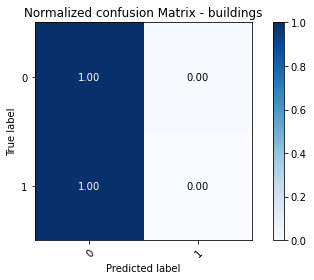

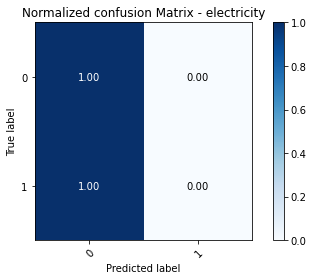

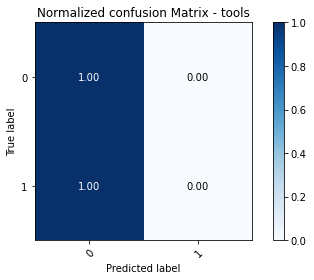

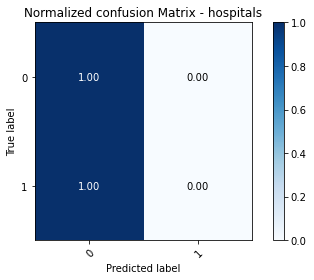

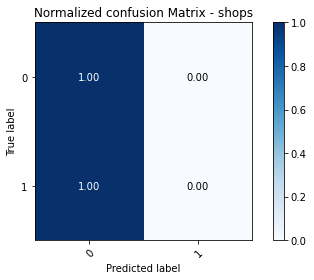

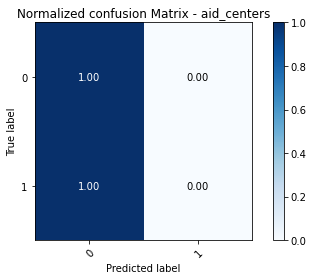

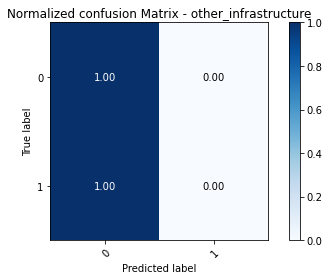

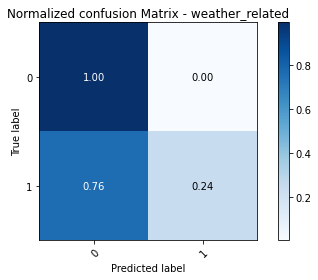

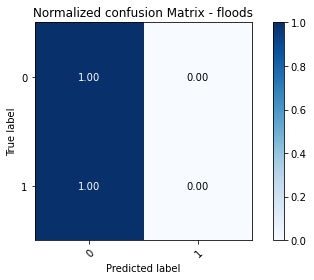

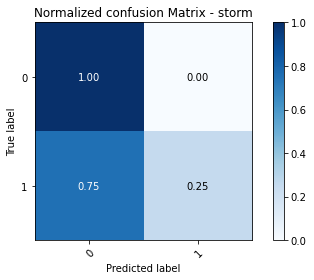

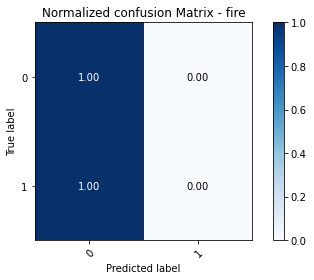

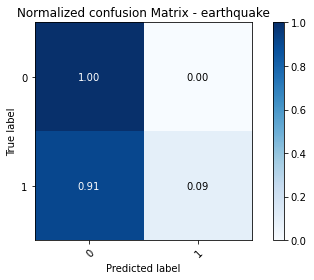

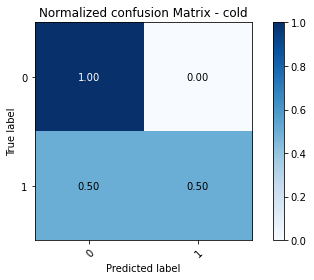

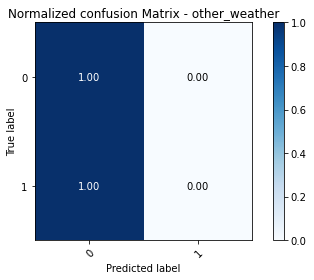

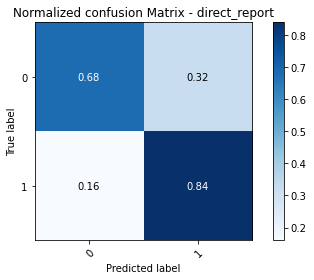

In [17]:
for i in range(Y_test.shape[1]):

    title = 'Normalized confusion Matrix - ' + Y_test.columns[i]

    classes = Y_test.iloc[:,i].unique()
    classes.sort()

    plot_confusion_matrix(Y_test.values[:,i], 
                          y_pred[:,i], 
                          classes= classes, title=title, normalize=True)


    plt.show()

### 6. Improve your model
Use grid search to find better parameters. 

In [18]:
X_train.shape

(750, 3)

In [19]:
weight1 = [{0:1,1:10,2:1}]
for i in range(8): weight1.append({0:1,1:10})
weight1.append({0:1})
for i in range(26): weight1.append({0:1,1:10})

weight2 = [{0:1,1:100,2:1}]
for i in range(8): weight2.append({0:1,1:100})
weight2.append({0:1})
for i in range(26): weight2.append({0:1,1:100})

weight3 = [{0:1,1:1000,2:1}]
for i in range(8): weight3.append({0:1,1:1000})
weight3.append({0:1})
for i in range(26): weight3.append({0:1,1:1000})


In [20]:
parameters ={'clf__estimator__n_estimators': [100],
             #'clf__estimator__min_samples_split': [2, 3, 4],
             'clf__estimator__max_features':["log2","sqrt"]
             # 'estimator__class_weight': [weight1, weight2, weight3]
            }

cv = GridSearchCV(model, param_grid = parameters, scoring = 'f1_samples')

In [21]:
startTime = time.time()
cv.fit(X_train, Y_train)

/home/guilherme/anaconda3/envs/Udacity/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['quoted_name']. An error will be raised in 1.2.
  warnings.warn(
/home/guilherme/anaconda3/envs/Udacity/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['quoted_name']. An error will be raised in 1.2.
  warnings.warn(
/home/guilherme/anaconda3/envs/Udacity/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['quoted_name']. An error will be raised in 1.2.
  warnings.warn(


[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.5s
[Pipeline] ............... (step 2 of 2) Processing clf, total=   4.8s


/home/guilherme/anaconda3/envs/Udacity/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['quoted_name']. An error will be raised in 1.2.
  warnings.warn(
/home/guilherme/anaconda3/envs/Udacity/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/guilherme/anaconda3/envs/Udacity/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/guilherme/anaconda3/envs/Udacity/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/home/guilherme/anaconda3/envs/Udacity/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return

[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.5s
[Pipeline] ............... (step 2 of 2) Processing clf, total=   4.8s


/home/guilherme/anaconda3/envs/Udacity/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['quoted_name']. An error will be raised in 1.2.
  warnings.warn(
/home/guilherme/anaconda3/envs/Udacity/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/guilherme/anaconda3/envs/Udacity/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/guilherme/anaconda3/envs/Udacity/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/home/guilherme/anaconda3/envs/Udacity/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return

[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.5s
[Pipeline] ............... (step 2 of 2) Processing clf, total=   4.9s


/home/guilherme/anaconda3/envs/Udacity/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['quoted_name']. An error will be raised in 1.2.
  warnings.warn(
/home/guilherme/anaconda3/envs/Udacity/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/guilherme/anaconda3/envs/Udacity/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/guilherme/anaconda3/envs/Udacity/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/home/guilherme/anaconda3/envs/Udacity/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return

[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.5s
[Pipeline] ............... (step 2 of 2) Processing clf, total=   4.8s


/home/guilherme/anaconda3/envs/Udacity/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['quoted_name']. An error will be raised in 1.2.
  warnings.warn(
/home/guilherme/anaconda3/envs/Udacity/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/guilherme/anaconda3/envs/Udacity/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/guilherme/anaconda3/envs/Udacity/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/home/guilherme/anaconda3/envs/Udacity/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return

[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.5s
[Pipeline] ............... (step 2 of 2) Processing clf, total=   4.9s


/home/guilherme/anaconda3/envs/Udacity/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['quoted_name']. An error will be raised in 1.2.
  warnings.warn(
/home/guilherme/anaconda3/envs/Udacity/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/guilherme/anaconda3/envs/Udacity/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/guilherme/anaconda3/envs/Udacity/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/home/guilherme/anaconda3/envs/Udacity/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return

[Pipeline] ............... (step 2 of 2) Processing clf, total=   5.1s


/home/guilherme/anaconda3/envs/Udacity/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['quoted_name']. An error will be raised in 1.2.
  warnings.warn(
/home/guilherme/anaconda3/envs/Udacity/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/guilherme/anaconda3/envs/Udacity/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/guilherme/anaconda3/envs/Udacity/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/home/guilherme/anaconda3/envs/Udacity/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return

[Pipeline] ............... (step 2 of 2) Processing clf, total=   5.0s


/home/guilherme/anaconda3/envs/Udacity/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['quoted_name']. An error will be raised in 1.2.
  warnings.warn(
/home/guilherme/anaconda3/envs/Udacity/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/guilherme/anaconda3/envs/Udacity/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/guilherme/anaconda3/envs/Udacity/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/home/guilherme/anaconda3/envs/Udacity/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return

[Pipeline] ............... (step 2 of 2) Processing clf, total=   5.0s


/home/guilherme/anaconda3/envs/Udacity/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['quoted_name']. An error will be raised in 1.2.
  warnings.warn(
/home/guilherme/anaconda3/envs/Udacity/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/guilherme/anaconda3/envs/Udacity/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/guilherme/anaconda3/envs/Udacity/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/home/guilherme/anaconda3/envs/Udacity/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return

[Pipeline] ............... (step 2 of 2) Processing clf, total=   5.0s


/home/guilherme/anaconda3/envs/Udacity/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['quoted_name']. An error will be raised in 1.2.
  warnings.warn(
/home/guilherme/anaconda3/envs/Udacity/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/guilherme/anaconda3/envs/Udacity/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/guilherme/anaconda3/envs/Udacity/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/home/guilherme/anaconda3/envs/Udacity/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return

[Pipeline] ............... (step 2 of 2) Processing clf, total=   4.8s


/home/guilherme/anaconda3/envs/Udacity/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['quoted_name']. An error will be raised in 1.2.
  warnings.warn(
/home/guilherme/anaconda3/envs/Udacity/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/guilherme/anaconda3/envs/Udacity/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/guilherme/anaconda3/envs/Udacity/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/home/guilherme/anaconda3/envs/Udacity/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return

[Pipeline] ............... (step 2 of 2) Processing clf, total=   5.2s


GridSearchCV(estimator=Pipeline(memory='/tmp/tmpkccakr6o',
                                steps=[('preprocess',
                                        ColumnTransformer(transformers=[('categories',
                                                                         OneHotEncoder(dtype='int'),
                                                                         ['genre']),
                                                                        ('messages',
                                                                         Pipeline(steps=[('count',
                                                                                          CountVectorizer(tokenizer=<function tokenize at 0x7fdc4bed6160>)),
                                                                                         ('tfidf',
                                                                                          TfidfTransformer())]),
                                                             

In [22]:
executionTime = time.time() - startTime
print(f'Execution time: {executionTime//3600:02.0f}:{(executionTime%3600)//60:02.0f}:{(executionTime%60):02.03f}')

Execution time: 00:01:2.666


In [23]:
cv.best_estimator_

Pipeline(memory='/tmp/tmpkccakr6o',
         steps=[('preprocess',
                 ColumnTransformer(transformers=[('categories',
                                                  OneHotEncoder(dtype='int'),
                                                  ['genre']),
                                                 ('messages',
                                                  Pipeline(steps=[('count',
                                                                   CountVectorizer(tokenizer=<function tokenize at 0x7fdc4bed6160>)),
                                                                  ('tfidf',
                                                                   TfidfTransformer())]),
                                                  'message')],
                                   verbose_feature_names_out=False)),
                ('clf',
                 MultiOutputClassifier(estimator=RandomForestClassifier(max_features='log2')))],
         verbose=True)

In [24]:
cv.best_score_

nan

In [25]:
cv.best_params_

{'clf__estimator__max_features': 'log2', 'clf__estimator__n_estimators': 100}

In [26]:
model = Pipeline([('preprocess', model[0]),
          ('clf', cv.best_estimator_)])

### 7. Test your model
Show the accuracy, precision, and recall of the tuned model.  

Since this project focuses on code quality, process, and  pipelines, there is no minimum performance metric needed to pass. However, make sure to fine tune your models for accuracy, precision and recall to make your project stand out - especially for your portfolio!

In [27]:
startTime = time.time()
y_pred = cv.predict(X_test)
executionTime = time.time() - startTime
print(f'Execution time: {executionTime//3600:02.0f}:{(executionTime%3600)//60:02.0f}:{(executionTime%60):02.03f}')

/home/guilherme/anaconda3/envs/Udacity/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['quoted_name']. An error will be raised in 1.2.
  warnings.warn(


Execution time: 00:00:0.762


In [28]:
for i in range(36):    
    print(labels[i])
    print(classification_report(Y_test.values[:,i], y_pred[:,i]))

related
              precision    recall  f1-score   support

           0       0.60      0.08      0.15        36
           1       0.86      0.99      0.92       212
           2       0.00      0.00      0.00         2

    accuracy                           0.85       250
   macro avg       0.49      0.36      0.36       250
weighted avg       0.81      0.85      0.80       250

request
              precision    recall  f1-score   support

           0       0.74      0.68      0.71       107
           1       0.78      0.83      0.80       143

    accuracy                           0.76       250
   macro avg       0.76      0.75      0.76       250
weighted avg       0.76      0.76      0.76       250

offer
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       250

    accuracy                           1.00       250
   macro avg       1.00      1.00      1.00       250
weighted avg       1.00      1.00      1.00       25

/home/guilherme/anaconda3/envs/Udacity/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/guilherme/anaconda3/envs/Udacity/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/guilherme/anaconda3/envs/Udacity/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

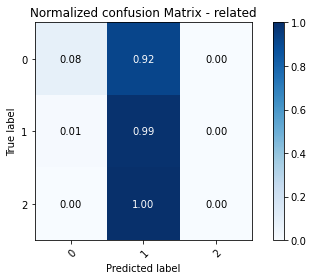

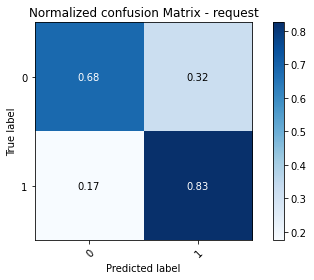

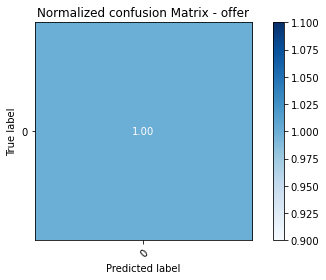

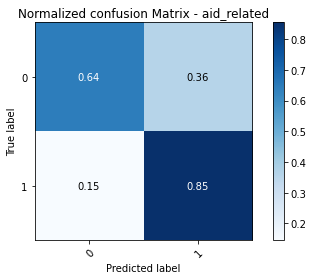

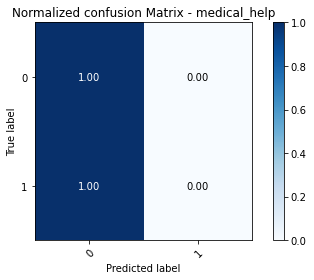

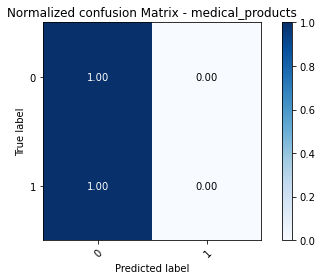

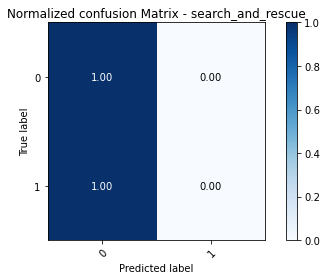

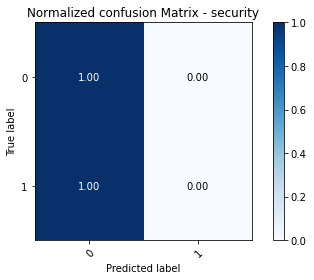

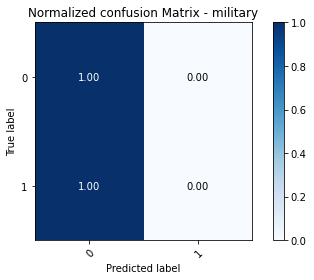

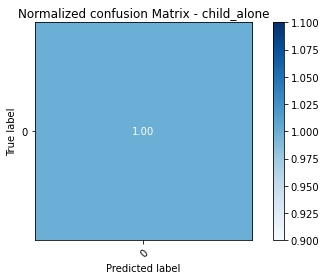

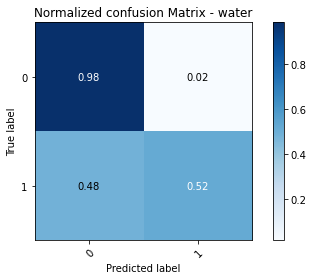

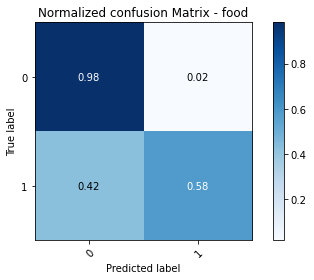

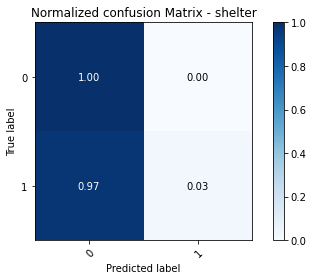

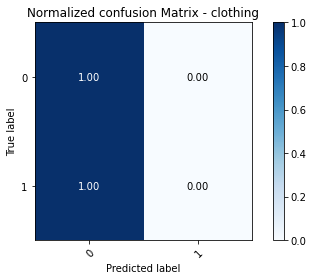

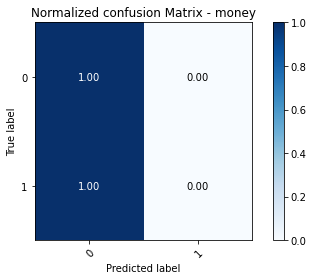

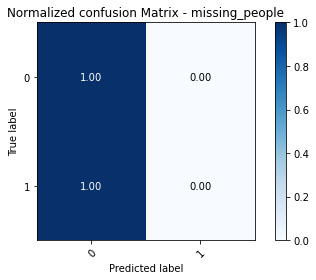

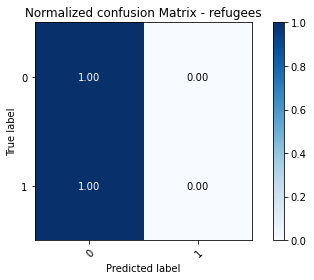

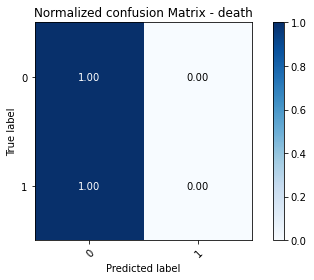

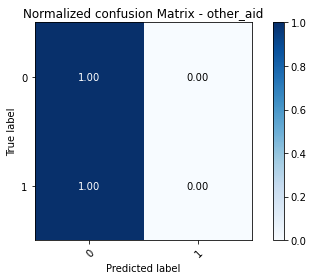

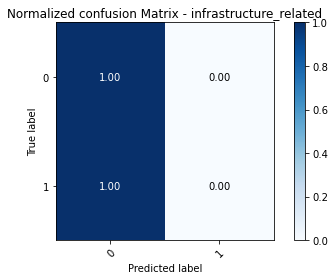

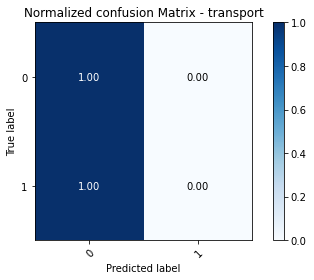

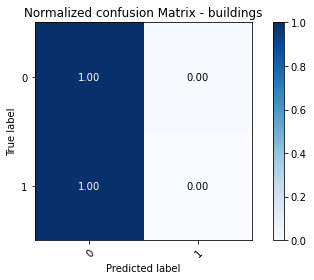

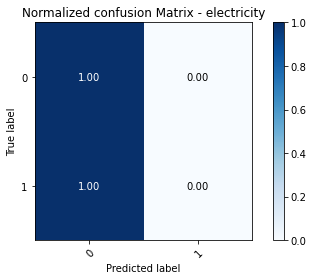

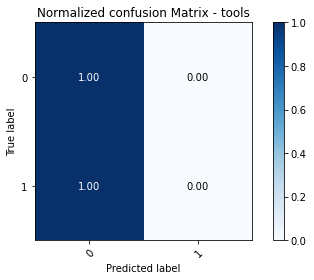

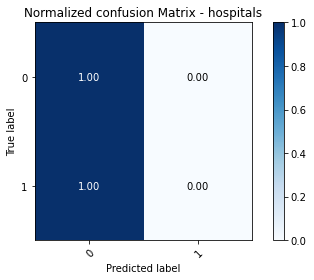

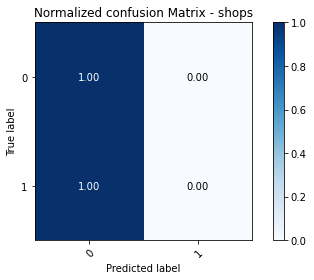

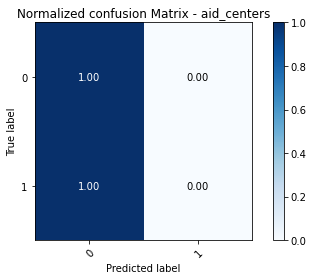

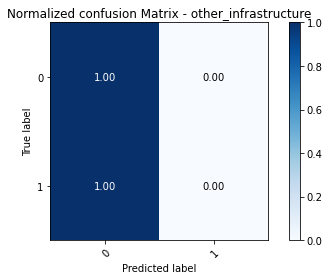

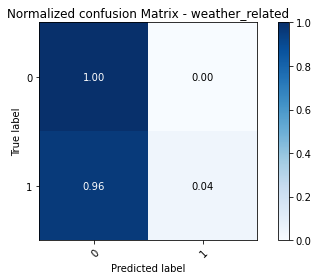

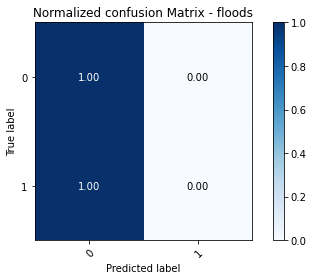

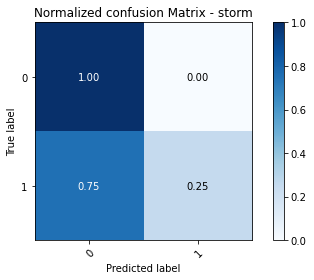

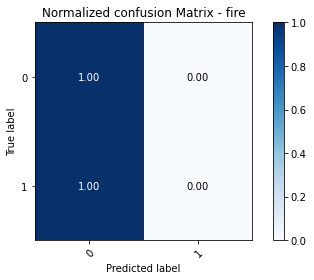

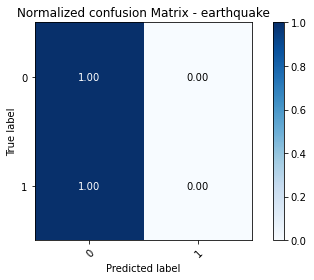

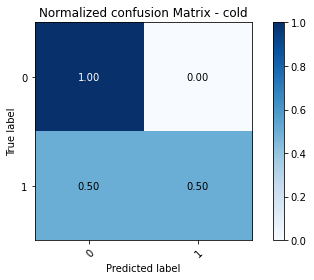

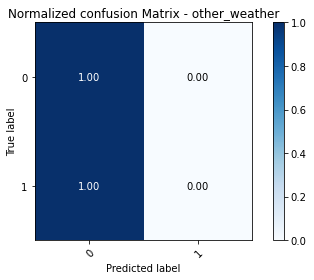

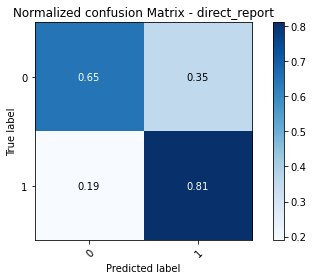

In [29]:
for i in range(Y_test.shape[1]):

    title = 'Normalized confusion Matrix - ' + Y_test.columns[i]

    classes = Y_test.iloc[:,i].unique()
    classes.sort()

    plot_confusion_matrix(Y_test.values[:,i], 
                          y_pred[:,i], 
                          classes= classes, title=title, normalize=True)


    plt.show()

### 8. Try improving your model further. Here are a few ideas:
* try other machine learning algorithms
* add other features besides the TF-IDF

In [30]:
rmtree(cachedir)

### 9. Export your model as a pickle file

In [31]:
with open('test.pkl', 'wb') as f:
    pickle.dump(model, f)    

### 10. Use this notebook to complete `train.py`
Use the template file attached in the Resources folder to write a script that runs the steps above to create a database and export a model based on a new dataset specified by the user.